In [1]:
###
import sys
sys.path.append('../lib')
import numpy as np
from numpy import exp, mod,meshgrid,pi,sin,size
import matplotlib.pyplot as plt
from sPOD_tools import frame, sPOD_distribute_residual
from transforms import transforms
''' to see the equations etc. you need jupyter-notebook extensions: 
https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/install.html
'''

# New shifted POD

Lets take a simple example of shifted cylinders in 2D: 
\begin{align}
            q(x,t) =q_1(\vec{x}-\vec{\Delta_1}{(t)},t)+q_2(x+\vec{\Delta}_2(t),t)\\
\end{align}
which is simply a time dependent transport with shifts.
Lets generate some data:


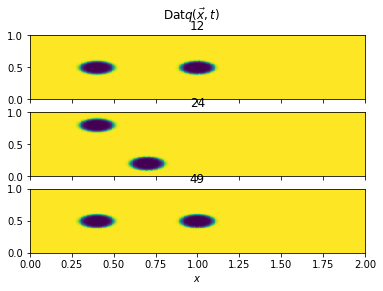

In [34]:
##########################################
#%% Define your DATA:
##########################################
plt.close("all")
Ngrid = [401, 202]  # number of grid points in x
Nt = 50            # Number of time intervalls
Nvar = 1            # Number of variables
nmodes = 1          # reduction of singular values

data_shape = [*Ngrid,Nvar,Nt]
               # size of time intervall
T = 2*pi                # total time
L = np.asarray([2, 1])   # total domain size
x0 = L*0.5               # starting point of the gauss puls
R = 0.1 * min(L)         # Radius of cylinder
x,y = (np.linspace(0, L[i], Ngrid[i]) for i in range(2))
time = np.linspace(0, T, Nt)
dx,dy = (x[1]-x[0],y[1]-y[0])
dt = time[1]-time[0]
c = dx/dt
[Y,X] = meshgrid(y,x)


f = lambda x,l : ((np.tanh(x/l) + 1 ) * 0.5)

phi1 = np.zeros(data_shape[:-2])
phi2 = np.zeros(data_shape[:-2])
q = np.zeros(data_shape)

shift1 = np.zeros([2,Nt])
shift2 = np.zeros([2,Nt])

center1 = (0.2*L[0],0.5*L[1])
center2 = (0.5*L[0],0.5*L[1])

for it,t in enumerate(time):
    
    x1,y1 = (center1[0], 0.3*L[1]*sin(t) + center1[1])
    x2,y2 = (center2[0]-0.3*L[1]*sin(t), - 0.3*L[1]*sin(t) + center2[1])
    
    phi1 = np.sqrt((X-x1)**2 + (Y-y1)**2) - R
    phi2 = np.sqrt((X-x2)**2 + (Y-y2)**2) - R
    
    shift1[0,it] = x1-center1[0]
    shift1[1,it] = y1-center1[1]
    
    shift2[0,it] = x2-center2[0]
    shift2[1,it] = y2-center2[1]
    
    q[...,0,it] = f(phi1,dx*3)*f(phi2,dx*3) 
    #q[...,1,it] = f(phi1,dx)-f(phi2,dx) 
fig,axs= plt.subplots(3,1,sharex=True)
fig.suptitle(r'Dat$q(\vec{x},t)$')
axs[0].pcolormesh(X,Y,q[...,0,0])
axs[0].set_title(0)
axs[1].pcolormesh(X,Y,q[...,0,it//4])
axs[1].set_title(it//4)
axs[2].pcolormesh(X,Y,q[...,0,it])
axs[2].set_title(it)
axs[2].set_xlabel(r'$x$')
plt.show()
plt.pause(0.001)
    

Now we try to decompose every frame in dyadic sturctures
\begin{equation*}
q_k(x,t) = \sum_{l=1}^{r_k} \alpha_l^k(t) \phi_l^k(x)
\end{equation*}
using the shifted POD.
The total field will be then given by:
\begin{equation}
                q(x,t) \approx \sum_{k=1}^{N} \sum_{l=1}^{r_k} \alpha_l^k(t) \phi_l^k(x - \Delta^k(t))
\end{equation}
Therefore we have to compute the discrete shift transformations first:

err =  3.7623e-03 


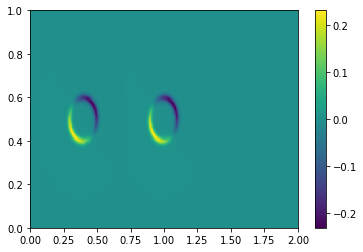

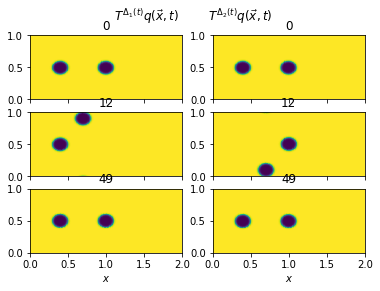

In [42]:
## Define shift trafos
shift_trafo_1 = transforms(data_shape,L, shifts = shift1, dx = [dx,dy] )
shift_trafo_2 = transforms(data_shape,L, shifts = shift2, dx = [dx,dy] )
qshift1 = shift_trafo_1.apply(q)
qshift2 = shift_trafo_2.apply(q)
qshiftreverse = shift_trafo_2.reverse(shift_trafo_2.apply(q))
res = q-qshiftreverse
err = np.linalg.norm(np.reshape(res,-1))/np.linalg.norm(np.reshape(q,-1))
print("err =  %4.4e "% err)

## plot the error of the shift
plt.pcolormesh(X,Y,q[...,0,0]-qshiftreverse[...,0,0])
plt.colorbar()
fig,axs= plt.subplots(3,2,sharex=True)
fig.suptitle(r' $T^{\Delta_1(t)}q(\vec{x},t)$            $T^{\Delta_2(t)}q(\vec{x},t)$')
axs[0,0].pcolormesh(X,Y,qshift1[...,0,0])
axs[0,0].set_title(0)
axs[1,0].pcolormesh(X,Y,qshift1[...,0,it//4])
axs[1,0].set_title(it//4)
axs[2,0].pcolormesh(X,Y,qshift1[...,0,it])
axs[2,0].set_title(it)
axs[2,0].set_xlabel(r'$x$')

axs[0,1].pcolormesh(X,Y,qshift2[...,0,0])
axs[0,1].set_title(0)
axs[1,1].pcolormesh(X,Y,qshift2[...,0,it//4])
axs[1,1].set_title(it//4)
axs[2,1].pcolormesh(X,Y,qshift2[...,0,it])
axs[2,1].set_title(it)
axs[2,1].set_xlabel(r'$x$')
plt.show()
plt.pause(0.001)

Lastly we want to seperate the two frames using the sPOD:

it=1 rel_err= 1.0000e+00
it=2 rel_err= 6.7037e-02
it=3 rel_err= 4.0985e-02
it=4 rel_err= 3.0380e-02
it=5 rel_err= 2.1178e-02
it=6 rel_err= 1.6748e-02
it=7 rel_err= 1.3401e-02
it=8 rel_err= 1.0378e-02
it=9 rel_err= 8.9762e-03
it=10 rel_err= 7.7139e-03
it=11 rel_err= 6.8862e-03
it=12 rel_err= 5.9456e-03
it=13 rel_err= 5.1118e-03
it=14 rel_err= 4.6328e-03
it=15 rel_err= 4.0971e-03
it=16 rel_err= 3.8039e-03
it=17 rel_err= 3.5069e-03
it=18 rel_err= 3.0527e-03
it=19 rel_err= 2.8883e-03
it=20 rel_err= 2.6036e-03


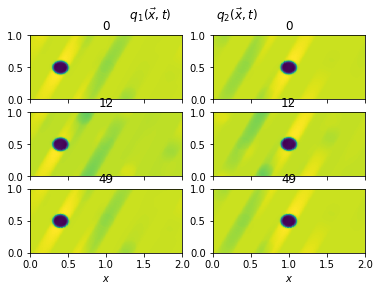

In [53]:
## compute sPOD
transforms = [shift_trafo_1, shift_trafo_2]
qframes, q = sPOD_distribute_residual(q, transforms, nmodes=2, eps=1e-4, Niter=20, visualize=True)

q1 = qframes[0].build_field()
q2 = qframes[1].build_field()


fig,axs= plt.subplots(3,2,sharex=True)
fig.suptitle(r' $q_1(\vec{x},t)$            $q_2(\vec{x},t)$')
axs[0,0].pcolormesh(X,Y,qshift1[...,0,0])
axs[0,0].pcolormesh(X,Y,q1[...,0,0])
axs[0,0].set_title(0)
axs[1,0].pcolormesh(X,Y,q1[...,0,it//4])
axs[1,0].set_title(it//4)
axs[2,0].pcolormesh(X,Y,q1[...,0,it])
axs[2,0].set_title(it)
axs[2,0].set_xlabel(r'$x$')

axs[0,1].pcolormesh(X,Y,q2[...,0,0])
axs[0,1].set_title(0)
axs[1,1].pcolormesh(X,Y,q2[...,0,it//4])
axs[1,1].set_title(it//4)
axs[2,1].pcolormesh(X,Y,q2[...,0,it])
axs[2,1].set_title(it)
axs[2,1].set_xlabel(r'$x$')
plt.show()
plt.pause(0.001)
